In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# # Install a pip package in the current Jupyter kernel
# import sys
# !{sys.executable} -m pip install torchsummary

In [13]:
import torch
from torch.utils.data import Dataset
from torch.utils.data.dataset import TensorDataset
from torch.distributions.multivariate_normal import MultivariateNormal
import torch.nn.functional as F
from torch_geometric.data import DataLoader
from torch_geometric.data import Data
from torch_geometric.utils.convert import to_networkx

import networkx as nx # for visualizing graphs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import pdb
from torchsummary import summary
import json
import pickle

from functions.load_data import MarielDataset, edges
from functions.functions import *
from functions.modules import *

# Load data

In [ ]:
batch_size = 32
seq_len = 10
predicted_timesteps = 0
data = MarielDataset(seq_len=seq_len, reduced_joints=False, predicted_timesteps=predicted_timesteps)
dataloader = DataLoader(data, batch_size=batch_size, shuffle=False, drop_last=True)
print("\nGenerated {:,} batches of shape: {}".format(len(dataloader), data[0]))

# Define model

In [ ]:
node_features = data.seq_len*data.n_dim
edge_features = data[0].num_edge_features
node_embedding_dim = 25
edge_embedding_dim = 4 # number of edge types
hidden_size = 50
num_layers = 2
checkpoint_path = "weights/checkpoint_53joints_seqlen10.pth"
checkpoint_loaded = False 

model = VAE(node_features=node_features, 
            edge_features=edge_features, 
            hidden_size=hidden_size, 
            node_embedding_dim=node_embedding_dim,
            edge_embedding_dim=edge_embedding_dim,
            num_layers=num_layers,
            input_size=node_embedding_dim, 
            output_size=node_features+predicted_timesteps*data.n_dim,
           )

optimizer = torch.optim.Adam(list(model.parameters()), lr=1e-4, weight_decay=5e-4)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using {}".format(device))
model = model.to(device)

print(model)
# gnn_model_summary(model)
print("Total trainable parameters: {:,}".format(count_parameters(model)))

### Optional: load pre-trained weights

Load the whole model + weights:

In [ ]:
# model = torch.load("weights/seqlen3_model.pth")

OR load the model state into the pre-existing model above:

In [ ]:
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss_checkpoint = checkpoint['loss']
checkpoint_loaded = True

# Train

In [ ]:
mse_loss = torch.nn.MSELoss(reduction='mean')
prediction_to_reconstruction_loss_ratio = 0 # you might want to weight the prediction loss higher to help it compete with the larger prediction seq_len
sigma = 0.001 # how to pick sigma?

def train(num_epochs):
    losses = []
    reconstruction_losses = []
    prediction_losses = []
    inputs = []
    outputs = []
    model.train()
    for epoch in range(num_epochs):
        average_loss = 0
        average_reconstruction_loss = 0
        average_prediction_loss = 0
        i = 0
        batch_inputs = []
        batch_outputs = []
        
        for batch in tqdm(dataloader, desc="Batches"):
            batch = batch.to(device)
            optimizer.zero_grad() # reset the gradients to zero
            
            ### CALCULATE MODEL OUTPUTS
            output = model(batch)
            batch_inputs.append(batch.x)
            batch_outputs.append(output)
            
            ### CALCULATE LOSS
            reconstruction_loss = mse_loss(batch.x.to(device), output[:,:node_features]) # compare first seq_len timesteps
            average_reconstruction_loss += reconstruction_loss.item()
            batch_loss = reconstruction_loss
            if predicted_timesteps > 0: 
                prediction_loss = mse_loss(batch.y.to(device), output[:,node_features:]) # compare last part to unseen data
                batch_loss += prediction_to_reconstruction_loss_ratio*prediction_loss
                average_prediction_loss += prediction_loss.item()

            ### BACKPROPAGATE
            batch_loss.backward()
            optimizer.step()
            average_loss += batch_loss.item()

            i += 1
            if i >= 3: break # temporary -- for stopping training early
                
        inputs.append(torch.stack(batch_inputs))
        outputs.append(torch.stack(batch_outputs))
        
        average_loss = average_loss / i # use len(dataloader) for full batches
        average_reconstruction_loss = average_reconstruction_loss / i # use len(dataloader) for full batches
        average_prediction_loss = average_prediction_loss / i # use len(dataloader) for full batches

        losses.append(average_loss) 
        reconstruction_losses.append(average_reconstruction_loss)
        prediction_losses.append(average_prediction_loss)
        print("epoch : {}/{} | Loss = {:,.4f} | Reconstruction Loss: {:,.4f} | Prediction Loss: {:,.4f}".format(epoch+1, num_epochs, average_loss, average_reconstruction_loss, average_prediction_loss))
        
        if epoch == 0 and not checkpoint_loaded: best_loss = average_loss
        elif epoch == 0 and checkpoint_loaded: best_loss = min(average_loss, loss_checkpoint)
            
        if average_loss < best_loss:
            best_loss = average_loss
            torch.save({
             'epoch': epoch,
             'model_state_dict': model.state_dict(),
             'optimizer_state_dict': optimizer.state_dict(),
             'loss': best_loss,
             }, checkpoint_path)
            print("Better loss achieved -- saved model checkpoint to {}.".format(checkpoint_path))
            
    return losses, reconstruction_losses, prediction_losses, inputs, outputs

In [ ]:
losses, reconstruction_losses, prediction_losses, inputs, outputs = train(num_epochs=1)

# Load losses & predictions from pickle/json files

In [21]:
dict = json.load(open("./logs/vae_53joints_seqlen49_pred0/losses.json"))
losses = dict['overall_losses']
reconstruction_losses = dict['reconstruction_losses']
prediction_losses = dict['prediction_losses']

In [22]:
inputs = np.load("./logs/vae_53joints_seqlen49_pred0/train_inputs.npy")
outputs = np.load("./logs/vae_53joints_seqlen49_pred0/train_outputs.npy")

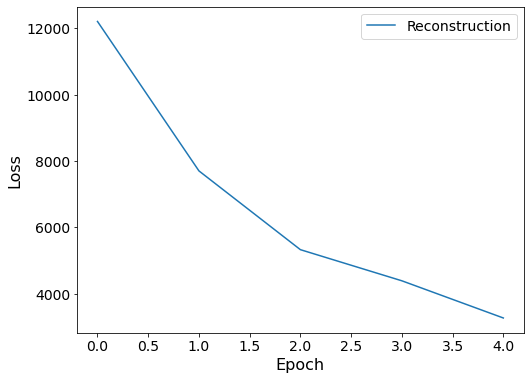

In [23]:
fig, ax = plt.subplots(figsize=(8,6))
# ax.plot(np.arange(len(losses)), losses, label="Total")
ax.plot(np.arange(len(losses)), reconstruction_losses, label="Reconstruction")
# ax.plot(np.arange(len(losses)), prediction_losses, label="Prediction")
ax.set_xlabel("Epoch", fontsize=16)
ax.set_ylabel("Loss", fontsize=16)
# ax.set_yscale("log")
# ax.set_ylim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.legend(fontsize=14)

In [33]:
first_input_batch = inputs[0]
n_joints = int(first_input_batch.shape[0]/32)
first_input_seq = first_input_batch[:n_joints, :]

# reshape to be n_joints x n_timesteps x n_dim
first_input_seq = first_input_seq.reshape((first_input_seq.shape[0],int(first_input_seq.shape[1]/3),3))

In [34]:
first_predicted_batch = outputs[0]
n_joints = int(first_predicted_batch.shape[0]/32)
first_predicted_seq = first_predicted_batch[:n_joints, :]

# reshape to be n_joints x n_timesteps x n_dim
first_predicted_seq = first_predicted_seq.reshape((first_predicted_seq.shape[0],int(first_predicted_seq.shape[1]/3),3))

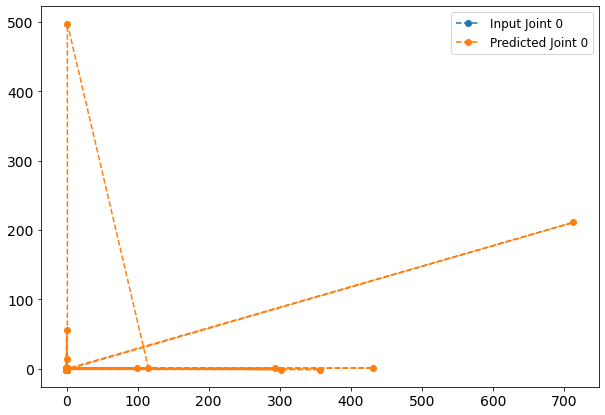

In [35]:
plt.figure(figsize=(10,7))
for joint in range(1): # first few joints
# for joint in range(first_seq.shape[0]): # all joints
    # plot x & y for the sequence
    plt.plot(first_input_seq[joint,:,0], first_input_seq[joint,:,1], 'o--', label="Input Joint "+str(joint)) 
    plt.plot(first_predicted_seq[joint,:,0], first_predicted_seq[joint,:,1], 'o--', label="Predicted Joint "+str(joint)) 
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)

### Up next:
- Try to overfit the input data (loss = 0) by setting prediction weight = 0
- Weight the prediction loss to ensure that the most immediate steps are more important to reconstruct than far future steps (like 1/2^t or something)

### For later:
- The Gaussian negative log likelihood loss functions will only make sense when the output of the decoder is mu (eq'n 16 & 17)

### Done
- ~~Predict 50 + k timesteps w/ separate MSE losses~~

# Scratch work

In [ ]:
#             my_nll_loss = gaussian_neg_log_likelihood(x=batch.x, mu=output, sigma=sigma)
#             nll_loss = nll_gaussian(preds=output, target=batch.x.to(device), variance=5e-5)
#             kl_loss = kl_categorical_uniform(torch.exp(log_probabilities), data[0].num_nodes, num_edge_types, add_const=True)